In [1]:
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import json

import plotly.io as pio
import re
from sklearn.linear_model import LinearRegression

pio.templates.default = "plotly_dark"
pio.renderers.default = "browser"

In [2]:
def get_salary_cap_events():
    ## Load json file from downloads
    with open('C:/Users/jrnas/Downloads/BBGM_League_1_2220_free_agency(1).json', encoding='latin') as f:
        r_json = json.load(f)

    return pd.DataFrame([(x['season'], x['text']) for x in r_json['events'] if 'An inflation rate of' in x['text']],
                        columns=['season', 'text'])


def extract_values(text):
    # Pattern for inflation rate
    inflation_pattern = r"(\d+(\.\d+)?)%"
    # Pattern for salary cap
    salary_cap_pattern = r"\$(\d+(\.\d+)?[MB]?)"

    # Search for the patterns
    inflation_match = re.search(inflation_pattern, text)
    salary_cap_match = re.search(salary_cap_pattern, text)

    # Extract the matched values
    inflation_rate = float(inflation_match.group(1)) if inflation_match else None
    salary_cap = salary_cap_match.group(1) if salary_cap_match else None

    return inflation_rate, salary_cap


def convert_salary_cap(salary_cap):
    if salary_cap.endswith('M'):
        return float(salary_cap[:-1])
    elif salary_cap.endswith('B'):
        return float(salary_cap[:-1]) * 1000
    else:
        return None


def get_salary_cap():
    inf_df = get_salary_cap_events()
    inf_df['inf_rate'], inf_df['salary_cap'] = zip(*inf_df['text'].apply(extract_values))
    inf_df['salary_cap'] = inf_df['salary_cap'].apply(convert_salary_cap)
    inf_df = inf_df[['season', 'inf_rate', 'salary_cap']]
    ## Add a row for 2023
    inf_df = pd.concat(
        [pd.DataFrame({'season': 2023, 'inf_rate': 0, 'salary_cap': 136}, index=[0]), inf_df]).reset_index(
        drop=True)
    ## Set up dictionary
    return inf_df.set_index('season').to_dict()['salary_cap']

In [3]:
salary_cap = get_salary_cap()

In [4]:
with open('C:/Users/jrnas/Downloads/BBGM_League_1_2220_free_agency.json', encoding='latin') as f:
    r_json = json.load(f)

In [5]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['stats']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid']
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
stats_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
)

stats_df = stats_df[(stats_df.season.between(2024, 2220)) & (stats_df.playoffs == False)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 25841.53it/s]


In [6]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['ratings']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid'],
            'firstName': player['firstName'],
            'lastName': player['lastName'],
            'born': player['born']['year'],
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
ratings_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
    .astype({'skills': 'string[pyarrow]'})
    .assign(
        age=lambda x: x.season - x.born,
    )
)

ratings_df = ratings_df[ratings_df.season.between(2024, 2220)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 65889.80it/s]


In [7]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['salaries']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid'],
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
salaries_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
)

salaries_df = salaries_df[salaries_df.season.between(2024, 2220)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 344245.38it/s]


In [8]:
df = ratings_df.merge(
    stats_df[['pid', 'season', 'tid', 'gp', 'gs', 'min', 'usgp', 'ortg', 'drtg', 'obpm', 'dbpm', 'ows', 'dws', 'vorp',
              'ewa']],
    on=['pid', 'season'], how='left').merge(
    salaries_df[['pid', 'season', 'amount']].rename(columns={'amount': 'salary'}), on=['pid', 'season'], how='left')

In [143]:
def build_cap_hit_model(df):
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    import pickle
    
    df['next_salary'] = df.groupby('pid')['salary'].shift(-1)
    df['cap_hit'] = df['salary'] / df['season'].map(salary_cap) / 1000
    df['next_cap_hit'] = df['next_salary'] / (df['season']).map(salary_cap) / 1000
    model_df = df[(df.salary != df.next_salary)][['age','ovr','pot','cap_hit','next_cap_hit']].dropna().reset_index(drop=True)

    features = ['age','ovr','pot']
    target = 'next_cap_hit'
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(model_df[features], model_df[target], test_size=0.2, random_state=42)
    
    model = XGBRegressor(early_stopping_rounds=10, learning_rate=0.1)
    
    # Fit the model using the training data and validate using the validation data
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    # Save the model to disk
    filename = '../models/cap_hit_model.pkl'
    pickle.dump(model, open(filename, 'wb'))

In [144]:
build_cap_hit_model(df)

[0]	validation_0-rmse:0.06125
[1]	validation_0-rmse:0.05619
[2]	validation_0-rmse:0.05173
[3]	validation_0-rmse:0.04778
[4]	validation_0-rmse:0.04433
[5]	validation_0-rmse:0.04128
[6]	validation_0-rmse:0.03864
[7]	validation_0-rmse:0.03634
[8]	validation_0-rmse:0.03437
[9]	validation_0-rmse:0.03266
[10]	validation_0-rmse:0.03121
[11]	validation_0-rmse:0.02998
[12]	validation_0-rmse:0.02892
[13]	validation_0-rmse:0.02803
[14]	validation_0-rmse:0.02729
[15]	validation_0-rmse:0.02664
[16]	validation_0-rmse:0.02612
[17]	validation_0-rmse:0.02568
[18]	validation_0-rmse:0.02532
[19]	validation_0-rmse:0.02501
[20]	validation_0-rmse:0.02476
[21]	validation_0-rmse:0.02455
[22]	validation_0-rmse:0.02438
[23]	validation_0-rmse:0.02423
[24]	validation_0-rmse:0.02412
[25]	validation_0-rmse:0.02403
[26]	validation_0-rmse:0.02396
[27]	validation_0-rmse:0.02390
[28]	validation_0-rmse:0.02384
[29]	validation_0-rmse:0.02381
[30]	validation_0-rmse:0.02377
[31]	validation_0-rmse:0.02374
[32]	validation_0-

In [134]:
model_df['pred_cap_hit'] = model.predict(model_df[features])

In [135]:
df['pred_cap_hit'] = model.predict(df[features].fillna(0))

In [136]:
df['pred_error'] = df['next_cap_hit'] - df['pred_cap_hit']

In [137]:
numeric_cols = df[df.salary != df.next_salary].select_dtypes(include=[np.number])
# Get correlation of all numeric columns with 'next_cap_hit'
correlation = numeric_cols.corr()['next_cap_hit']

In [140]:
df[(df.salary != df.next_salary)].sort_values('pred_error',ascending=False)[['firstName','lastName','season','age','ovr','pot','cap_hit','next_cap_hit','pred_cap_hit','pred_error']]

,firstName,lastName,season,age,ovr,pot,cap_hit,next_cap_hit,pred_cap_hit,pred_error
143204,Luke,Rose,2205,28,57,57,0.033603,0.187664,0.045568,0.142095
68579,Eric,Ligon,2108,24,56,62,0.038941,0.260629,0.127621,0.133009
144479,Courtney,Torbert,2203,26,55,57,0.060638,0.207587,0.074766,0.132821
72364,Stephen,Rodriguez,2113,24,57,61,0.015119,0.243369,0.111590,0.131779
42130,Apolo,Mariano,2074,23,57,61,0.013168,0.236738,0.107630,0.129109
...,...,...,...,...,...,...,...,...,...,...
3382,Anthony,Black,2027,23,56,64,0.052283,0.038574,0.140164,-0.101589
1696,Jalen,Williams,2026,25,65,68,0.034062,0.119923,0.221652,-0.101729
130927,Marquel,Rollins,2183,23,61,69,0.048002,0.110395,0.219182,-0.108787
6021,Jett,Howard,2027,23,61,67,0.03698,0.091813,0.208384,-0.11657


<Axes: xlabel='pred_cap_hit', ylabel='next_cap_hit'>

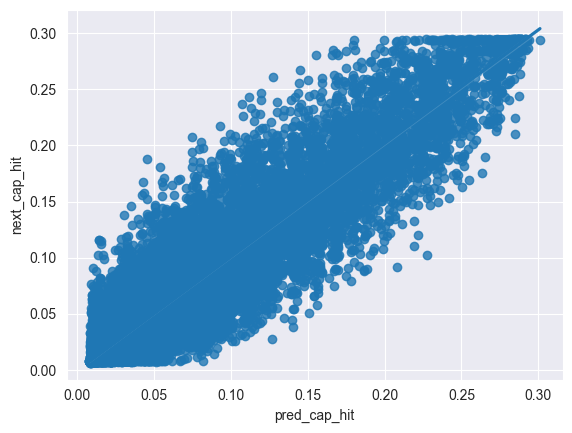

In [139]:
import seaborn as sns
sns.regplot(data=model_df, x='pred_cap_hit', y='next_cap_hit')

In [ ]:
|